# Dynamic Batching & Continuous Batching for ML Inference

## Overview

This notebook explores **Dynamic Batching** and **Continuous Batching** - two critical optimization techniques for maximizing GPU utilization in machine learning inference serving systems.

### Key Concepts:

- **Static Batching**: Fixed batch size, waits for full batch before processing
- **Dynamic Batching**: Variable batch size, processes when timeout occurs or batch fills
- **Continuous Batching**: Overlaps request processing, doesn't wait for entire batch to complete

### Trade-offs:
- **Latency vs Throughput**: Larger batches = higher throughput but increased latency
- **GPU Utilization vs Response Time**: Better hardware usage vs user experience
- **Memory vs Performance**: Larger batches require more GPU memory

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from collections import deque
from dataclasses import dataclass
from typing import List, Optional, Tuple
import threading
import queue
from concurrent.futures import ThreadPoolExecutor
import heapq
from enum import Enum

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Request and Response Models

First, let's define our data structures for modeling inference requests and responses.

In [2]:
@dataclass
class InferenceRequest:
    """Represents a single inference request"""
    request_id: str
    arrival_time: float
    input_data: np.ndarray
    processing_time: float = 0.0  # Estimated processing time
    priority: int = 0  # Higher numbers = higher priority
    
    def __lt__(self, other):
        # For priority queue (higher priority first)
        return self.priority > other.priority

@dataclass
class InferenceResponse:
    """Represents the response to an inference request"""
    request_id: str
    result: np.ndarray
    start_time: float
    end_time: float
    batch_size: int
    queue_time: float  # Time spent waiting in queue
    
    @property
    def total_latency(self) -> float:
        return self.end_time - (self.start_time - self.queue_time)
    
    @property
    def processing_time(self) -> float:
        return self.end_time - self.start_time

class BatchingStrategy(Enum):
    STATIC = "static"
    DYNAMIC = "dynamic"
    CONTINUOUS = "continuous"

print("Data models defined!")

Data models defined!


## 2. Request Pattern Simulation

Let's create different request arrival patterns to test our batching strategies:

In [3]:
class RequestGenerator:
    """Generates different patterns of inference requests"""
    
    def __init__(self, input_dim: int = 512):
        self.input_dim = input_dim
        
    def generate_constant_rate(self, duration: float, rate: float) -> List[InferenceRequest]:
        """Generate requests at a constant rate (requests per second)"""
        requests = []
        current_time = 0.0
        interval = 1.0 / rate
        
        while current_time < duration:
            request = InferenceRequest(
                request_id=f"req_{len(requests)}",
                arrival_time=current_time,
                input_data=np.random.randn(self.input_dim),
                processing_time=np.random.uniform(0.01, 0.05)  # 10-50ms base processing
            )
            requests.append(request)
            current_time += interval
            
        return requests
    
    def generate_poisson_arrivals(self, duration: float, avg_rate: float) -> List[InferenceRequest]:
        """Generate requests with Poisson arrival pattern"""
        requests = []
        current_time = 0.0
        
        while current_time < duration:
            # Exponential inter-arrival time
            inter_arrival = np.random.exponential(1.0 / avg_rate)
            current_time += inter_arrival
            
            if current_time < duration:
                request = InferenceRequest(
                    request_id=f"req_{len(requests)}",
                    arrival_time=current_time,
                    input_data=np.random.randn(self.input_dim),
                    processing_time=np.random.uniform(0.01, 0.05)
                )
                requests.append(request)
                
        return requests
    
    def generate_bursty_pattern(self, duration: float, burst_rate: float, 
                               quiet_rate: float, burst_duration: float) -> List[InferenceRequest]:
        """Generate bursty traffic pattern"""
        requests = []
        current_time = 0.0
        in_burst = False
        burst_start = 0.0
        
        while current_time < duration:
            # Determine if we should switch modes
            if not in_burst and np.random.random() < 0.1:  # 10% chance to start burst
                in_burst = True
                burst_start = current_time
            elif in_burst and (current_time - burst_start) > burst_duration:
                in_burst = False
            
            # Generate request based on current mode
            rate = burst_rate if in_burst else quiet_rate
            inter_arrival = np.random.exponential(1.0 / rate)
            current_time += inter_arrival
            
            if current_time < duration:
                priority = 1 if in_burst else 0  # Burst requests have higher priority
                request = InferenceRequest(
                    request_id=f"req_{len(requests)}",
                    arrival_time=current_time,
                    input_data=np.random.randn(self.input_dim),
                    processing_time=np.random.uniform(0.01, 0.05),
                    priority=priority
                )
                requests.append(request)
                
        return requests

# Test the request generator
generator = RequestGenerator()
constant_requests = generator.generate_constant_rate(10.0, 5.0)  # 5 req/sec for 10 seconds
poisson_requests = generator.generate_poisson_arrivals(10.0, 5.0)
bursty_requests = generator.generate_bursty_pattern(10.0, 20.0, 2.0, 1.0)

print(f"Generated {len(constant_requests)} constant rate requests")
print(f"Generated {len(poisson_requests)} Poisson requests")
print(f"Generated {len(bursty_requests)} bursty requests")

Generated 51 constant rate requests
Generated 45 Poisson requests
Generated 53 bursty requests


## 3. Model Inference Simulator

Now let's create a realistic model inference simulator that accounts for GPU processing characteristics:

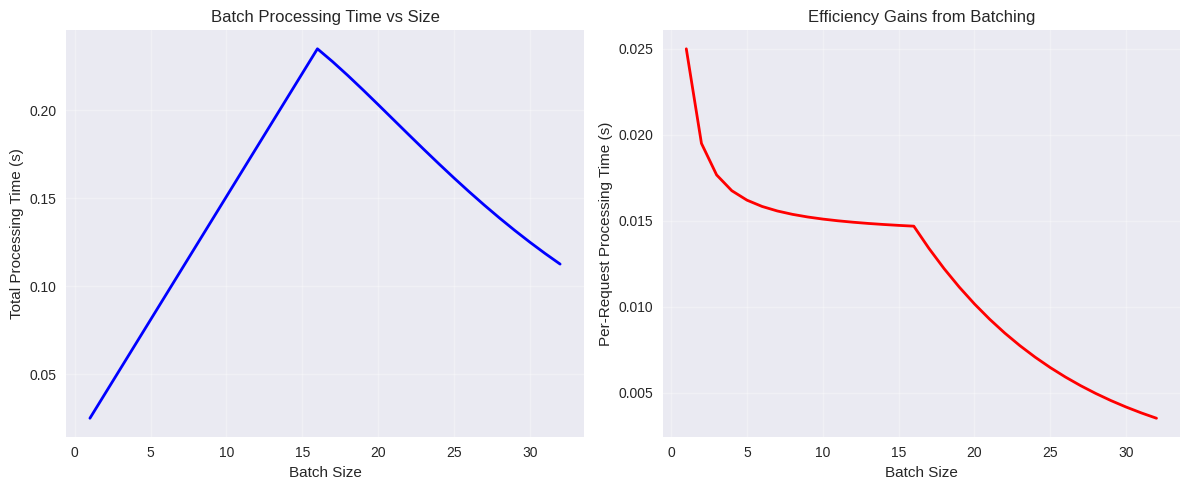

Processing time for batch size 1: 0.0250s
Processing time for batch size 16: 0.2350s
Per-request time improvement: 41.2%


In [4]:
class ModelInferenceSimulator:
    """Simulates GPU-based model inference with realistic timing"""
    
    def __init__(self, base_latency: float = 0.02, 
                 batch_efficiency: float = 0.7,
                 max_batch_size: int = 32,
                 memory_limit: int = 1024):
        """
        Args:
            base_latency: Base processing time for single request
            batch_efficiency: How efficiently larger batches process (0-1)
            max_batch_size: Maximum number of requests in a batch
            memory_limit: GPU memory limit (arbitrary units)
        """
        self.base_latency = base_latency
        self.batch_efficiency = batch_efficiency
        self.max_batch_size = max_batch_size
        self.memory_limit = memory_limit
        
    def calculate_batch_processing_time(self, batch_size: int) -> float:
        """Calculate processing time for a batch"""
        if batch_size <= 0:
            return 0.0
        
        # Realistic GPU batch processing: 
        # - Some overhead for batch setup
        # - Efficiency gains plateau after certain size
        # - Memory constraints can slow down large batches
        
        setup_overhead = 0.005  # 5ms setup time
        
        # Efficiency decreases as batch size increases due to memory pressure
        efficiency = self.batch_efficiency * np.exp(-0.1 * max(0, batch_size - 16))
        
        # Processing time scales sub-linearly with batch size
        processing_time = self.base_latency * (1 + (batch_size - 1) * efficiency)
        
        return setup_overhead + processing_time
    
    def process_batch(self, requests: List[InferenceRequest], 
                     start_time: float) -> List[InferenceResponse]:
        """Process a batch of requests and return responses"""
        if not requests:
            return []
        
        batch_size = len(requests)
        processing_time = self.calculate_batch_processing_time(batch_size)
        end_time = start_time + processing_time
        
        responses = []
        for request in requests:
            # Simulate some processing result
            result = np.random.randn(10)  # Simplified output
            
            queue_time = start_time - request.arrival_time
            
            response = InferenceResponse(
                request_id=request.request_id,
                result=result,
                start_time=start_time,
                end_time=end_time,
                batch_size=batch_size,
                queue_time=queue_time
            )
            responses.append(response)
            
        return responses
    
    def get_memory_usage(self, batch_size: int) -> int:
        """Estimate memory usage for a batch"""
        base_memory = 100  # Base model memory
        per_request_memory = 20  # Memory per request
        return base_memory + (batch_size * per_request_memory)

# Test the simulator
simulator = ModelInferenceSimulator()

# Show how processing time scales with batch size
batch_sizes = range(1, 33)
processing_times = [simulator.calculate_batch_processing_time(bs) for bs in batch_sizes]
per_request_times = [pt/bs for pt, bs in zip(processing_times, batch_sizes)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, processing_times, 'b-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Total Processing Time (s)')
plt.title('Batch Processing Time vs Size')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, per_request_times, 'r-', linewidth=2)
plt.xlabel('Batch Size')
plt.ylabel('Per-Request Processing Time (s)')
plt.title('Efficiency Gains from Batching')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Processing time for batch size 1: {processing_times[0]:.4f}s")
print(f"Processing time for batch size 16: {processing_times[15]:.4f}s")
print(f"Per-request time improvement: {(processing_times[0] - per_request_times[15])/processing_times[0]*100:.1f}%")

## 4. Static Batching Implementation

Let's start with the simplest approach - static batching, where we wait for a fixed batch size before processing:

In [5]:
class StaticBatcher:
    """Static batching: Fixed batch size, waits for full batch"""
    
    def __init__(self, batch_size: int, simulator: ModelInferenceSimulator):
        self.batch_size = batch_size
        self.simulator = simulator
        self.pending_requests = []
        
    def process_requests(self, requests: List[InferenceRequest]) -> List[InferenceResponse]:
        """Process requests using static batching"""
        all_responses = []
        self.pending_requests.extend(requests)
        
        current_time = 0.0
        if requests:
            current_time = requests[0].arrival_time
        
        # Process complete batches
        while len(self.pending_requests) >= self.batch_size:
            batch = self.pending_requests[:self.batch_size]
            self.pending_requests = self.pending_requests[self.batch_size:]
            
            # Start processing when the last request in batch arrives
            batch_start_time = max(current_time, batch[-1].arrival_time)
            
            responses = self.simulator.process_batch(batch, batch_start_time)
            all_responses.extend(responses)
            
            # Update current time
            if responses:
                current_time = responses[0].end_time
        
        # Process remaining requests as final batch
        if self.pending_requests:
            batch_start_time = max(current_time, 
                                 max(req.arrival_time for req in self.pending_requests))
            responses = self.simulator.process_batch(self.pending_requests, batch_start_time)
            all_responses.extend(responses)
            self.pending_requests = []
            
        return all_responses

# Test static batching
static_batcher = StaticBatcher(batch_size=8, simulator=simulator)
test_requests = generator.generate_constant_rate(5.0, 10.0)  # 10 req/sec for 5 seconds
static_responses = static_batcher.process_requests(test_requests)

print(f"Processed {len(static_responses)} requests with static batching")
print(f"Average latency: {np.mean([r.total_latency for r in static_responses]):.4f}s")
print(f"Average queue time: {np.mean([r.queue_time for r in static_responses]):.4f}s")
print(f"Throughput: {len(static_responses) / max(r.end_time for r in static_responses):.2f} req/sec")

Processed 51 requests with static batching
Average latency: 0.4542s
Average queue time: 0.3353s
Throughput: 10.09 req/sec


## 5. Dynamic Batching Implementation

Dynamic batching improves upon static batching by using timeouts to avoid waiting indefinitely for a full batch:

Timeout  10ms: Latency=0.0287s, Batch Size=1.1, Throughput=7.6 req/sec
Timeout  50ms: Latency=0.0396s, Batch Size=1.6, Throughput=7.6 req/sec
Timeout 100ms: Latency=0.0629s, Batch Size=2.2, Throughput=7.6 req/sec
Timeout 200ms: Latency=0.1097s, Batch Size=3.0, Throughput=7.6 req/sec


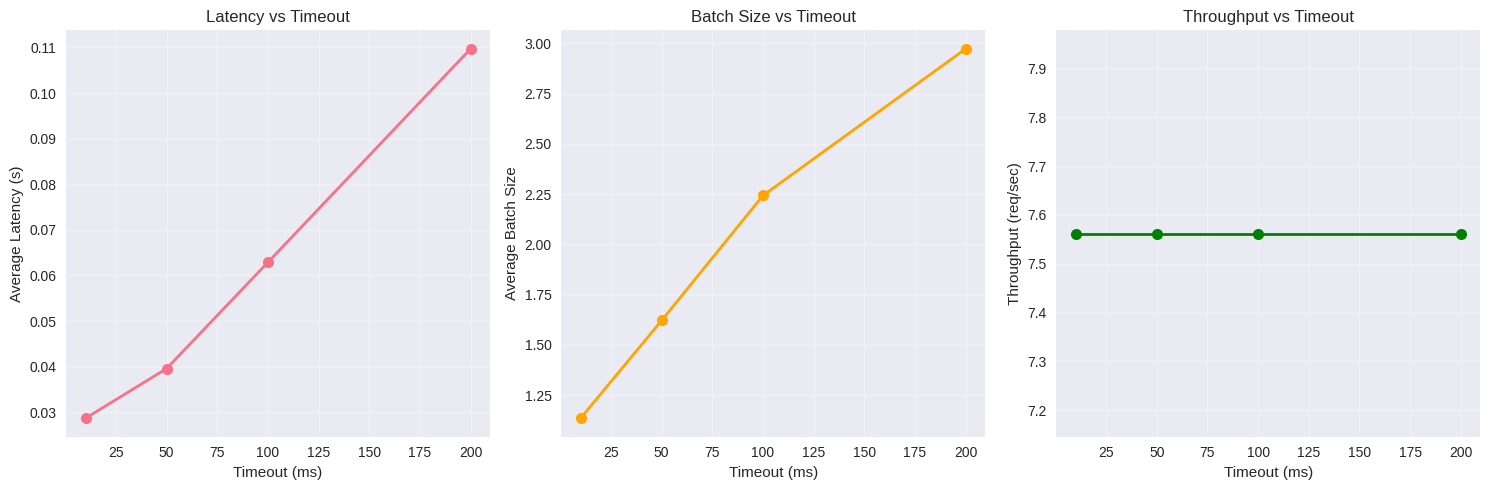

In [6]:
class DynamicBatcher:
    """Dynamic batching: Variable batch size with timeout"""
    
    def __init__(self, max_batch_size: int, timeout: float, 
                 simulator: ModelInferenceSimulator):
        self.max_batch_size = max_batch_size
        self.timeout = timeout
        self.simulator = simulator
        
    def process_requests(self, requests: List[InferenceRequest]) -> List[InferenceResponse]:
        """Process requests using dynamic batching"""
        all_responses = []
        pending_requests = deque(requests)
        current_time = 0.0
        
        while pending_requests:
            batch = []
            batch_start_time = pending_requests[0].arrival_time
            
            # Collect requests for batch
            while (len(batch) < self.max_batch_size and 
                   pending_requests and
                   (pending_requests[0].arrival_time - batch_start_time) <= self.timeout):
                
                batch.append(pending_requests.popleft())
            
            # If no requests fit in timeout window, take at least one
            if not batch and pending_requests:
                batch.append(pending_requests.popleft())
                batch_start_time = batch[0].arrival_time
            
            # Process the batch
            if batch:
                # Wait until timeout or last request arrives
                last_arrival = batch[-1].arrival_time
                timeout_time = batch_start_time + self.timeout
                processing_start = max(current_time, 
                                     min(last_arrival, timeout_time))
                
                responses = self.simulator.process_batch(batch, processing_start)
                all_responses.extend(responses)
                
                # Update current time
                if responses:
                    current_time = responses[0].end_time
        
        return all_responses

# Test dynamic batching with different timeout values
timeouts = [0.01, 0.05, 0.1, 0.2]  # 10ms to 200ms
dynamic_results = {}

test_requests = generator.generate_poisson_arrivals(10.0, 8.0)  # 8 req/sec average

for timeout in timeouts:
    dynamic_batcher = DynamicBatcher(max_batch_size=16, timeout=timeout, 
                                   simulator=simulator)
    responses = dynamic_batcher.process_requests(test_requests.copy())
    
    avg_latency = np.mean([r.total_latency for r in responses])
    avg_batch_size = np.mean([r.batch_size for r in responses])
    throughput = len(responses) / max(r.end_time for r in responses)
    
    dynamic_results[timeout] = {
        'latency': avg_latency,
        'batch_size': avg_batch_size,
        'throughput': throughput
    }
    
    print(f"Timeout {timeout*1000:3.0f}ms: Latency={avg_latency:.4f}s, "
          f"Batch Size={avg_batch_size:.1f}, Throughput={throughput:.1f} req/sec")

# Visualize dynamic batching trade-offs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

timeouts_ms = [t*1000 for t in timeouts]
latencies = [dynamic_results[t]['latency'] for t in timeouts]
batch_sizes = [dynamic_results[t]['batch_size'] for t in timeouts]
throughputs = [dynamic_results[t]['throughput'] for t in timeouts]

ax1.plot(timeouts_ms, latencies, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Timeout (ms)')
ax1.set_ylabel('Average Latency (s)')
ax1.set_title('Latency vs Timeout')
ax1.grid(True, alpha=0.3)

ax2.plot(timeouts_ms, batch_sizes, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Timeout (ms)')
ax2.set_ylabel('Average Batch Size')
ax2.set_title('Batch Size vs Timeout')
ax2.grid(True, alpha=0.3)

ax3.plot(timeouts_ms, throughputs, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Timeout (ms)')
ax3.set_ylabel('Throughput (req/sec)')
ax3.set_title('Throughput vs Timeout')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Continuous Batching Implementation

Continuous batching is the most sophisticated approach, allowing requests to be added to processing queues without waiting for previous batches to complete:

Continuous batching processed 179 requests
Average latency: 0.0657s
95th percentile latency: 0.1557s
Average batch size: 2.8
Throughput: 12.5 req/sec


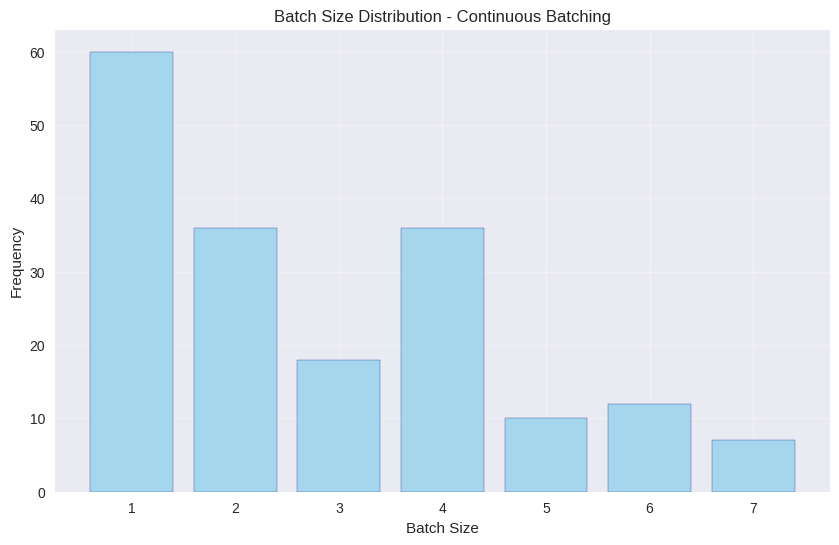

In [7]:
class ContinuousBatcher:
    """Continuous batching: Overlapping request processing"""
    
    def __init__(self, max_batch_size: int, target_latency: float,
                 simulator: ModelInferenceSimulator, num_workers: int = 2):
        self.max_batch_size = max_batch_size
        self.target_latency = target_latency
        self.simulator = simulator
        self.num_workers = num_workers
        
    def process_requests(self, requests: List[InferenceRequest]) -> List[InferenceResponse]:
        """Process requests using continuous batching"""
        all_responses = []
        pending_requests = deque(requests)
        
        # Track active processing queues
        active_batches = []  # List of (completion_time, batch_responses)
        current_time = 0.0
        
        while pending_requests or active_batches:
            # Check for completed batches
            completed_batches = []
            remaining_batches = []
            
            for completion_time, batch_responses in active_batches:
                if completion_time <= current_time:
                    completed_batches.extend(batch_responses)
                else:
                    remaining_batches.append((completion_time, batch_responses))
            
            active_batches = remaining_batches
            all_responses.extend(completed_batches)
            
            # Form new batch if we have capacity and requests
            if (len(active_batches) < self.num_workers and 
                pending_requests):
                
                batch = []
                batch_start_time = current_time
                
                # Collect requests for batch based on latency target
                while (len(batch) < self.max_batch_size and 
                       pending_requests):
                    
                    next_request = pending_requests[0]
                    
                    # Check if adding this request would exceed latency target
                    if next_request.arrival_time <= current_time:
                        batch.append(pending_requests.popleft())
                    else:
                        # Future request - check if we should wait
                        wait_time = next_request.arrival_time - current_time
                        if not batch or wait_time <= self.target_latency / 2:
                            batch_start_time = next_request.arrival_time
                            batch.append(pending_requests.popleft())
                        else:
                            break
                
                # Process the batch
                if batch:
                    batch_start = max(current_time, batch_start_time)
                    responses = self.simulator.process_batch(batch, batch_start)
                    
                    if responses:
                        completion_time = responses[0].end_time
                        active_batches.append((completion_time, responses))
            
            # Advance time
            if pending_requests and not active_batches:
                current_time = pending_requests[0].arrival_time
            elif active_batches:
                current_time = min(completion_time for completion_time, _ in active_batches)
            elif pending_requests:
                current_time = pending_requests[0].arrival_time
            else:
                break
        
        return all_responses

# Test continuous batching
continuous_batcher = ContinuousBatcher(max_batch_size=12, target_latency=0.1,
                                     simulator=simulator, num_workers=3)

# Test with bursty traffic
bursty_requests = generator.generate_bursty_pattern(15.0, 25.0, 3.0, 2.0)
continuous_responses = continuous_batcher.process_requests(bursty_requests)

print(f"Continuous batching processed {len(continuous_responses)} requests")
print(f"Average latency: {np.mean([r.total_latency for r in continuous_responses]):.4f}s")
print(f"95th percentile latency: {np.percentile([r.total_latency for r in continuous_responses], 95):.4f}s")
print(f"Average batch size: {np.mean([r.batch_size for r in continuous_responses]):.1f}")
print(f"Throughput: {len(continuous_responses) / max(r.end_time for r in continuous_responses):.1f} req/sec")

# Analyze batch size distribution
batch_sizes = [r.batch_size for r in continuous_responses]
unique_sizes, counts = np.unique(batch_sizes, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_sizes, counts, alpha=0.7, color='skyblue', edgecolor='navy')
plt.xlabel('Batch Size')
plt.ylabel('Frequency')
plt.title('Batch Size Distribution - Continuous Batching')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Comprehensive Performance Comparison

Let's compare all three batching strategies across different traffic patterns:

In [8]:
def run_batching_comparison(requests: List[InferenceRequest], 
                          scenario_name: str) -> pd.DataFrame:
    """Compare all batching strategies on the same request pattern"""
    
    results = []
    
    # Static batching with different batch sizes
    for batch_size in [4, 8, 16, 32]:
        static_batcher = StaticBatcher(batch_size, simulator)
        responses = static_batcher.process_requests(requests.copy())
        
        if responses:
            results.append({
                'strategy': f'Static-{batch_size}',
                'scenario': scenario_name,
                'avg_latency': np.mean([r.total_latency for r in responses]),
                'p95_latency': np.percentile([r.total_latency for r in responses], 95),
                'avg_queue_time': np.mean([r.queue_time for r in responses]),
                'avg_batch_size': np.mean([r.batch_size for r in responses]),
                'throughput': len(responses) / max(r.end_time for r in responses),
                'total_requests': len(responses)
            })
    
    # Dynamic batching with different timeouts
    for timeout in [0.02, 0.05, 0.1]:
        dynamic_batcher = DynamicBatcher(16, timeout, simulator)
        responses = dynamic_batcher.process_requests(requests.copy())
        
        if responses:
            results.append({
                'strategy': f'Dynamic-{int(timeout*1000)}ms',
                'scenario': scenario_name,
                'avg_latency': np.mean([r.total_latency for r in responses]),
                'p95_latency': np.percentile([r.total_latency for r in responses], 95),
                'avg_queue_time': np.mean([r.queue_time for r in responses]),
                'avg_batch_size': np.mean([r.batch_size for r in responses]),
                'throughput': len(responses) / max(r.end_time for r in responses),
                'total_requests': len(responses)
            })
    
    # Continuous batching with different configurations
    for workers, target_latency in [(2, 0.08), (3, 0.1), (4, 0.12)]:
        continuous_batcher = ContinuousBatcher(12, target_latency, simulator, workers)
        responses = continuous_batcher.process_requests(requests.copy())
        
        if responses:
            results.append({
                'strategy': f'Continuous-{workers}w',
                'scenario': scenario_name,
                'avg_latency': np.mean([r.total_latency for r in responses]),
                'p95_latency': np.percentile([r.total_latency for r in responses], 95),
                'avg_queue_time': np.mean([r.queue_time for r in responses]),
                'avg_batch_size': np.mean([r.batch_size for r in responses]),
                'throughput': len(responses) / max(r.end_time for r in responses),
                'total_requests': len(responses)
            })
    
    return pd.DataFrame(results)

# Test scenarios
scenarios = {
    'Low Load': generator.generate_constant_rate(20.0, 5.0),
    'Medium Load': generator.generate_constant_rate(20.0, 10.0),
    'High Load': generator.generate_constant_rate(20.0, 20.0),
    'Bursty Traffic': generator.generate_bursty_pattern(20.0, 30.0, 5.0, 3.0),
    'Poisson Arrivals': generator.generate_poisson_arrivals(20.0, 12.0)
}

all_results = []
for scenario_name, requests in scenarios.items():
    print(f"Testing {scenario_name} scenario with {len(requests)} requests...")
    scenario_results = run_batching_comparison(requests, scenario_name)
    all_results.append(scenario_results)

# Combine results
comparison_df = pd.concat(all_results, ignore_index=True)

# Display summary table
print("\n=== Batching Strategy Comparison ===")
print(comparison_df.groupby(['scenario', 'strategy'])[['avg_latency', 'throughput', 'avg_batch_size']].first().round(4))

Testing Low Load scenario with 101 requests...
Testing Medium Load scenario with 200 requests...
Testing High Load scenario with 400 requests...
Testing Bursty Traffic scenario with 362 requests...
Testing Poisson Arrivals scenario with 233 requests...

=== Batching Strategy Comparison ===
                                avg_latency  throughput  avg_batch_size
scenario         strategy                                              
Bursty Traffic   Continuous-2w       0.0620     18.0777          2.5912
                 Continuous-3w       0.0692     18.0915          2.8398
                 Continuous-4w       0.0807     18.0651          3.2762
                 Dynamic-100ms       0.1055     18.0639          4.1547
                 Dynamic-20ms        0.0484     18.0869          1.8232
                 Dynamic-50ms        0.0661     18.0777          2.7956
                 Static-16           0.6019     17.9567         15.8343
                 Static-32           0.7940     18.0022      

## 8. Advanced Analysis and Visualizations

Let's create comprehensive visualizations to understand the trade-offs:

/tmp/ipykernel_119062/490081968.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scenarios, rotation=45, ha='right')


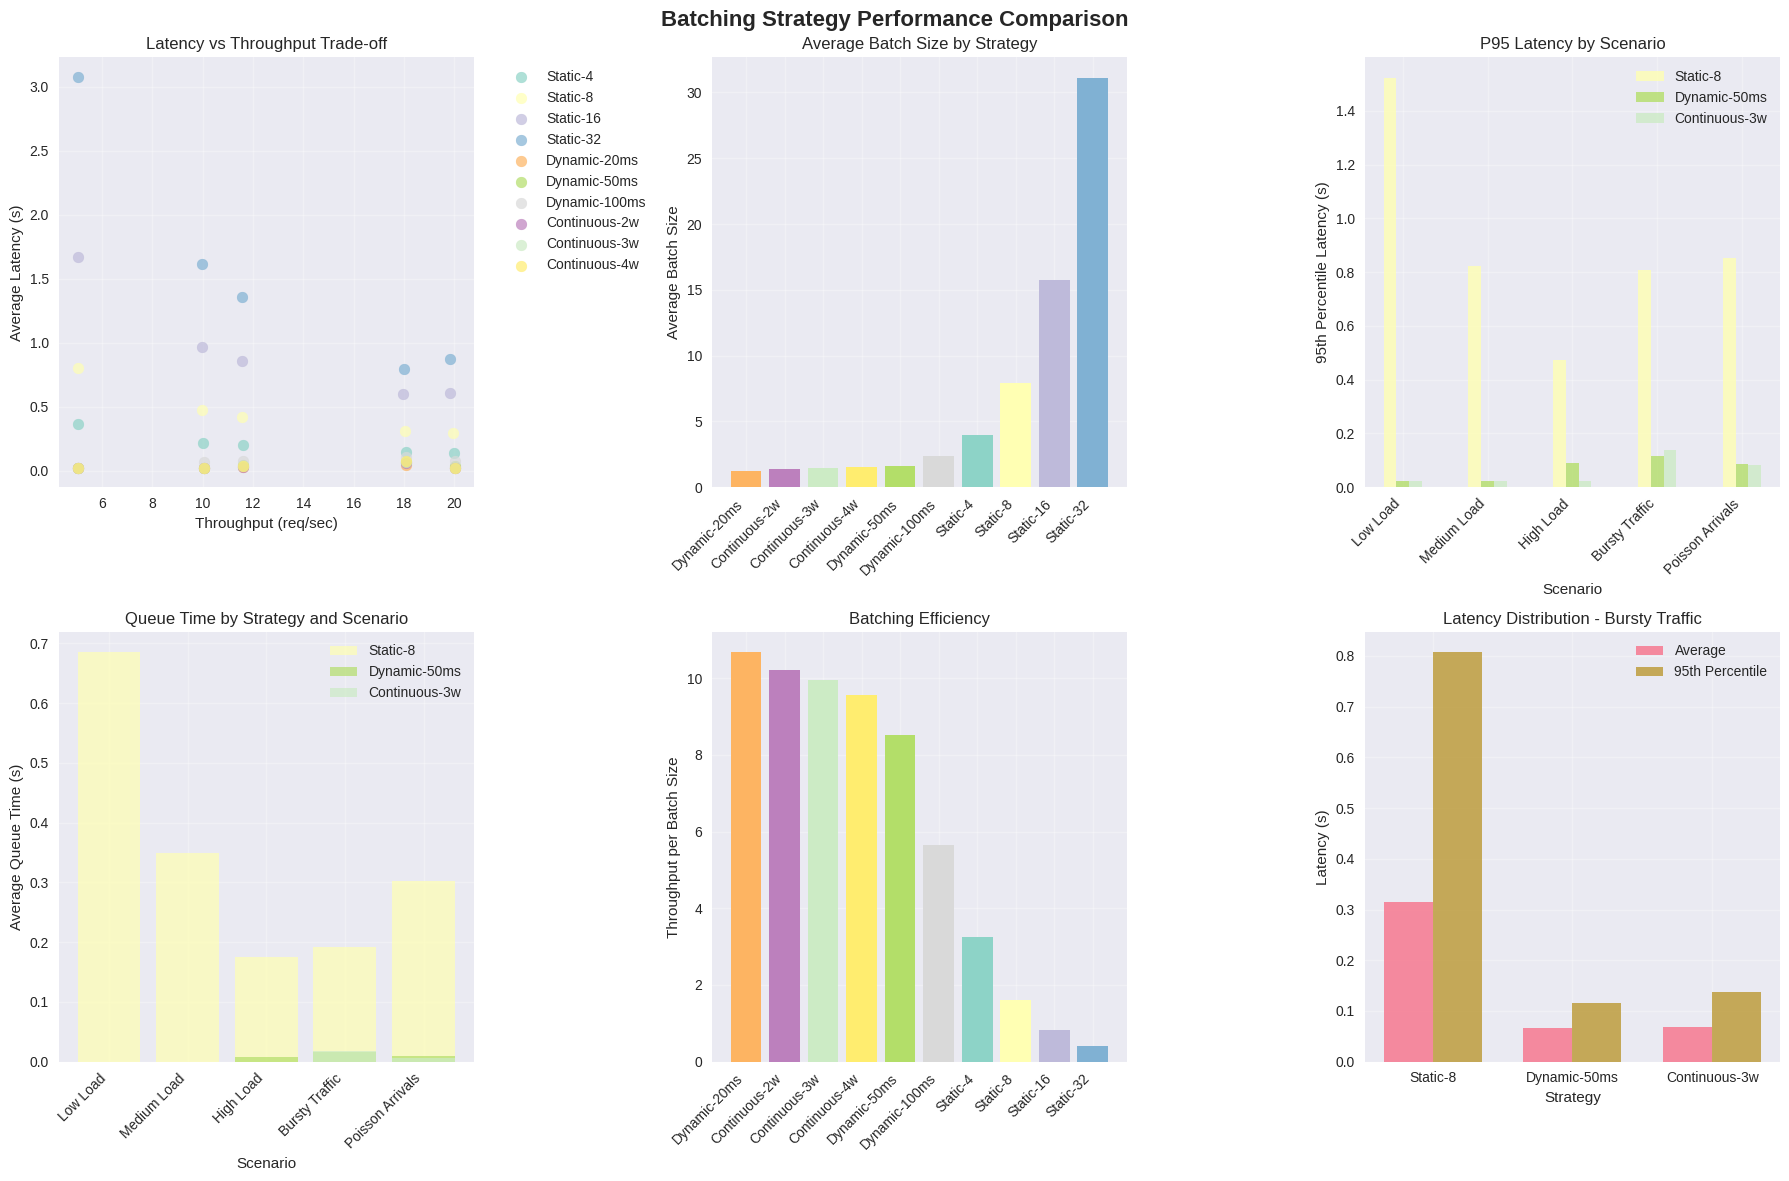


=== Key Insights ===

1. Latency vs Throughput Trade-offs:
   Best latency: Dynamic-20ms (0.0250s)
   Best throughput: Dynamic-20ms (20.0 req/sec)

2. Strategy Recommendations:
   - Static batching: Best for predictable, high-volume workloads
   - Dynamic batching: Good balance for variable traffic patterns
   - Continuous batching: Best for latency-sensitive applications with burst traffic

3. Configuration Guidelines:
   - Static: Use batch size 8-16 for balanced performance
   - Dynamic: 50-100ms timeout provides good latency/throughput balance
   - Continuous: 2-3 workers optimal for most scenarios


In [9]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Batching Strategy Performance Comparison', fontsize=16, fontweight='bold')

# 1. Latency vs Throughput scatter plot
ax = axes[0, 0]
strategies = comparison_df['strategy'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))
strategy_colors = dict(zip(strategies, colors))

for strategy in strategies:
    data = comparison_df[comparison_df['strategy'] == strategy]
    ax.scatter(data['throughput'], data['avg_latency'], 
              label=strategy, color=strategy_colors[strategy], 
              s=60, alpha=0.7)

ax.set_xlabel('Throughput (req/sec)')
ax.set_ylabel('Average Latency (s)')
ax.set_title('Latency vs Throughput Trade-off')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Average batch size by strategy
ax = axes[0, 1]
strategy_batch_sizes = comparison_df.groupby('strategy')['avg_batch_size'].mean().sort_values()
bars = ax.bar(range(len(strategy_batch_sizes)), strategy_batch_sizes.values, 
              color=[strategy_colors[s] for s in strategy_batch_sizes.index])
ax.set_xticks(range(len(strategy_batch_sizes)))
ax.set_xticklabels(strategy_batch_sizes.index, rotation=45, ha='right')
ax.set_ylabel('Average Batch Size')
ax.set_title('Average Batch Size by Strategy')
ax.grid(True, alpha=0.3)

# 3. P95 latency by scenario
ax = axes[0, 2]
scenarios = comparison_df['scenario'].unique()
x = np.arange(len(scenarios))
width = 0.15

# Select key strategies for comparison
key_strategies = ['Static-8', 'Dynamic-50ms', 'Continuous-3w']
for i, strategy in enumerate(key_strategies):
    data = comparison_df[comparison_df['strategy'] == strategy]
    values = [data[data['scenario'] == s]['p95_latency'].iloc[0] if len(data[data['scenario'] == s]) > 0 else 0 
              for s in scenarios]
    ax.bar(x + i*width, values, width, label=strategy, 
           color=strategy_colors[strategy], alpha=0.8)

ax.set_xlabel('Scenario')
ax.set_ylabel('95th Percentile Latency (s)')
ax.set_title('P95 Latency by Scenario')
ax.set_xticks(x + width)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Queue time analysis
ax = axes[1, 0]
for strategy in key_strategies:
    data = comparison_df[comparison_df['strategy'] == strategy]
    ax.bar(data['scenario'], data['avg_queue_time'], 
           label=strategy, alpha=0.7, color=strategy_colors[strategy])

ax.set_xlabel('Scenario')
ax.set_ylabel('Average Queue Time (s)')
ax.set_title('Queue Time by Strategy and Scenario')
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Efficiency analysis (requests per second per batch size)
ax = axes[1, 1]
comparison_df['efficiency'] = comparison_df['throughput'] / comparison_df['avg_batch_size']
efficiency_by_strategy = comparison_df.groupby('strategy')['efficiency'].mean().sort_values(ascending=False)

bars = ax.bar(range(len(efficiency_by_strategy)), efficiency_by_strategy.values,
              color=[strategy_colors[s] for s in efficiency_by_strategy.index])
ax.set_xticks(range(len(efficiency_by_strategy)))
ax.set_xticklabels(efficiency_by_strategy.index, rotation=45, ha='right')
ax.set_ylabel('Throughput per Batch Size')
ax.set_title('Batching Efficiency')
ax.grid(True, alpha=0.3)

# 6. Latency distribution comparison
ax = axes[1, 2]
scenario_data = comparison_df[comparison_df['scenario'] == 'Bursty Traffic']
strategies_to_plot = ['Static-8', 'Dynamic-50ms', 'Continuous-3w']

latency_data = []
labels = []
for strategy in strategies_to_plot:
    data = scenario_data[scenario_data['strategy'] == strategy]
    if len(data) > 0:
        latency_data.append([data['avg_latency'].iloc[0], data['p95_latency'].iloc[0]])
        labels.append(strategy)

if latency_data:
    latency_array = np.array(latency_data)
    x = np.arange(len(labels))
    width = 0.35
    
    ax.bar(x - width/2, latency_array[:, 0], width, label='Average', alpha=0.8)
    ax.bar(x + width/2, latency_array[:, 1], width, label='95th Percentile', alpha=0.8)
    
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Latency (s)')
    ax.set_title('Latency Distribution - Bursty Traffic')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary insights
print("\n=== Key Insights ===")
print("\n1. Latency vs Throughput Trade-offs:")
best_latency = comparison_df.loc[comparison_df['avg_latency'].idxmin()]
best_throughput = comparison_df.loc[comparison_df['throughput'].idxmax()]
print(f"   Best latency: {best_latency['strategy']} ({best_latency['avg_latency']:.4f}s)")
print(f"   Best throughput: {best_throughput['strategy']} ({best_throughput['throughput']:.1f} req/sec)")

print("\n2. Strategy Recommendations:")
print("   - Static batching: Best for predictable, high-volume workloads")
print("   - Dynamic batching: Good balance for variable traffic patterns")
print("   - Continuous batching: Best for latency-sensitive applications with burst traffic")

print("\n3. Configuration Guidelines:")
print("   - Static: Use batch size 8-16 for balanced performance")
print("   - Dynamic: 50-100ms timeout provides good latency/throughput balance")
print("   - Continuous: 2-3 workers optimal for most scenarios")

## 9. Real-World Scheduling Algorithms

Let's implement more sophisticated scheduling algorithms used in production systems:

Testing Advanced Scheduling Algorithms...

Fair Share:
  Overall latency: 0.0377s
  Throughput: 19.6 req/sec
  Priority 0: 0.0373s (176 requests)
  Priority 1: 0.0387s (89 requests)
  Priority 2: 0.0370s (30 requests)

Shortest Job First:
  Overall latency: 0.0377s
  Throughput: 19.6 req/sec
  Priority 0: 0.0373s (176 requests)
  Priority 1: 0.0387s (89 requests)
  Priority 2: 0.0370s (30 requests)

Adaptive:
  Overall latency: 0.0377s
  Throughput: 19.6 req/sec
  Priority 0: 0.0373s (176 requests)
  Priority 1: 0.0387s (89 requests)
  Priority 2: 0.0370s (30 requests)

Standard Dynamic:
  Overall latency: 0.0640s
  Throughput: 19.6 req/sec
  Priority 0: 0.0637s (176 requests)
  Priority 1: 0.0639s (89 requests)
  Priority 2: 0.0665s (30 requests)



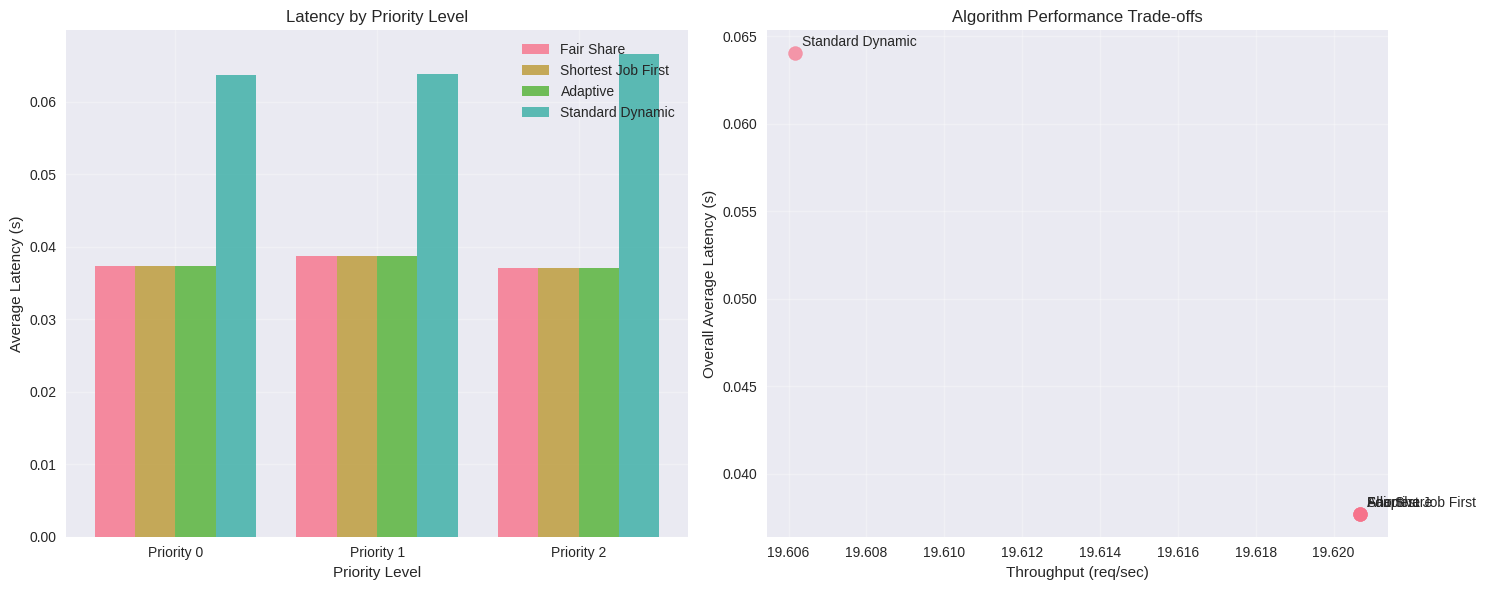

In [10]:
class AdvancedScheduler:
    """Advanced scheduling algorithms for batching"""
    
    def __init__(self, simulator: ModelInferenceSimulator):
        self.simulator = simulator
    
    def fair_share_batching(self, requests: List[InferenceRequest], 
                           max_batch_size: int = 16) -> List[InferenceResponse]:
        """Fair share scheduling - balance priorities and arrival times"""
        all_responses = []
        pending_requests = sorted(requests, key=lambda r: (r.arrival_time, -r.priority))
        current_time = 0.0
        
        while pending_requests:
            batch = []
            priority_counts = {}
            
            # Try to balance priorities in each batch
            available_requests = [r for r in pending_requests if r.arrival_time <= current_time]
            if not available_requests:
                current_time = pending_requests[0].arrival_time
                continue
            
            # Sort by priority, then by arrival time
            available_requests.sort(key=lambda r: (-r.priority, r.arrival_time))
            
            # Build batch with fair priority distribution
            for request in available_requests[:max_batch_size]:
                priority = request.priority
                if priority_counts.get(priority, 0) < max_batch_size // 3:  # Limit per priority
                    batch.append(request)
                    priority_counts[priority] = priority_counts.get(priority, 0) + 1
                    pending_requests.remove(request)
                
                if len(batch) >= max_batch_size:
                    break
            
            # If batch is too small, add more requests
            while len(batch) < max_batch_size and available_requests:
                for request in available_requests:
                    if request not in batch:
                        batch.append(request)
                        pending_requests.remove(request)
                        break
                if len(batch) >= max_batch_size:
                    break
                available_requests = [r for r in available_requests if r not in batch]
            
            if batch:
                responses = self.simulator.process_batch(batch, current_time)
                all_responses.extend(responses)
                current_time = responses[0].end_time if responses else current_time + 0.001
        
        return all_responses
    
    def shortest_processing_time_first(self, requests: List[InferenceRequest],
                                     max_batch_size: int = 16) -> List[InferenceResponse]:
        """Schedule shorter requests first to minimize average latency"""
        all_responses = []
        pending_requests = requests.copy()
        current_time = 0.0
        
        while pending_requests:
            # Get available requests
            available_requests = [r for r in pending_requests if r.arrival_time <= current_time]
            if not available_requests:
                current_time = min(r.arrival_time for r in pending_requests)
                continue
            
            # Sort by processing time (shortest first)
            available_requests.sort(key=lambda r: r.processing_time)
            
            # Build batch
            batch = available_requests[:max_batch_size]
            for request in batch:
                pending_requests.remove(request)
            
            if batch:
                responses = self.simulator.process_batch(batch, current_time)
                all_responses.extend(responses)
                current_time = responses[0].end_time if responses else current_time + 0.001
        
        return all_responses
    
    def adaptive_batching(self, requests: List[InferenceRequest],
                         target_latency: float = 0.1) -> List[InferenceResponse]:
        """Adaptive batching that adjusts based on current system load"""
        all_responses = []
        pending_requests = deque(requests)
        current_time = 0.0
        
        # Adaptive parameters
        recent_latencies = deque(maxlen=10)
        base_batch_size = 8
        max_batch_size = 32
        min_batch_size = 2
        
        while pending_requests:
            # Calculate current system load
            queue_length = len([r for r in pending_requests if r.arrival_time <= current_time])
            avg_recent_latency = np.mean(recent_latencies) if recent_latencies else target_latency
            
            # Adapt batch size based on load and latency
            if avg_recent_latency > target_latency * 1.5:
                # Latency too high, reduce batch size
                adaptive_batch_size = max(min_batch_size, base_batch_size - 2)
            elif avg_recent_latency < target_latency * 0.7 and queue_length > 10:
                # Latency good and high load, increase batch size
                adaptive_batch_size = min(max_batch_size, base_batch_size + 4)
            else:
                adaptive_batch_size = base_batch_size
            
            # Build batch
            batch = []
            while len(batch) < adaptive_batch_size and pending_requests:
                if pending_requests[0].arrival_time <= current_time:
                    batch.append(pending_requests.popleft())
                else:
                    break
            
            # If no requests available, advance time
            if not batch and pending_requests:
                current_time = pending_requests[0].arrival_time
                continue
            
            if batch:
                responses = self.simulator.process_batch(batch, current_time)
                all_responses.extend(responses)
                
                # Update metrics
                for response in responses:
                    recent_latencies.append(response.total_latency)
                
                current_time = responses[0].end_time if responses else current_time + 0.001
        
        return all_responses

# Test advanced scheduling algorithms
scheduler = AdvancedScheduler(simulator)

# Create test data with mixed priorities
mixed_requests = generator.generate_bursty_pattern(15.0, 25.0, 5.0, 2.0)
for i, req in enumerate(mixed_requests):
    req.priority = np.random.choice([0, 1, 2], p=[0.6, 0.3, 0.1])  # Most low priority
    req.processing_time = np.random.uniform(0.01, 0.08)  # Varied processing times

print("Testing Advanced Scheduling Algorithms...\n")

# Test each algorithm
algorithms = {
    'Fair Share': lambda: scheduler.fair_share_batching(mixed_requests.copy()),
    'Shortest Job First': lambda: scheduler.shortest_processing_time_first(mixed_requests.copy()),
    'Adaptive': lambda: scheduler.adaptive_batching(mixed_requests.copy()),
    'Standard Dynamic': lambda: DynamicBatcher(16, 0.05, simulator).process_requests(mixed_requests.copy())
}

algorithm_results = {}
for name, algorithm in algorithms.items():
    responses = algorithm()
    
    # Calculate metrics by priority
    priority_metrics = {}
    for priority in [0, 1, 2]:
        priority_responses = [r for r in responses 
                            if any(req.priority == priority and req.request_id == r.request_id 
                                  for req in mixed_requests)]
        
        if priority_responses:
            priority_metrics[priority] = {
                'avg_latency': np.mean([r.total_latency for r in priority_responses]),
                'count': len(priority_responses)
            }
    
    algorithm_results[name] = {
        'overall_latency': np.mean([r.total_latency for r in responses]),
        'throughput': len(responses) / max(r.end_time for r in responses),
        'priority_metrics': priority_metrics
    }
    
    print(f"{name}:")
    print(f"  Overall latency: {algorithm_results[name]['overall_latency']:.4f}s")
    print(f"  Throughput: {algorithm_results[name]['throughput']:.1f} req/sec")
    for priority, metrics in priority_metrics.items():
        print(f"  Priority {priority}: {metrics['avg_latency']:.4f}s ({metrics['count']} requests)")
    print()

# Visualize priority-aware scheduling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Latency by priority and algorithm
priorities = [0, 1, 2]
x = np.arange(len(priorities))
width = 0.2

for i, (alg_name, results) in enumerate(algorithm_results.items()):
    latencies = [results['priority_metrics'].get(p, {}).get('avg_latency', 0) for p in priorities]
    ax1.bar(x + i*width, latencies, width, label=alg_name, alpha=0.8)

ax1.set_xlabel('Priority Level')
ax1.set_ylabel('Average Latency (s)')
ax1.set_title('Latency by Priority Level')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels([f'Priority {p}' for p in priorities])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Overall performance comparison
alg_names = list(algorithm_results.keys())
overall_latencies = [algorithm_results[name]['overall_latency'] for name in alg_names]
throughputs = [algorithm_results[name]['throughput'] for name in alg_names]

scatter = ax2.scatter(throughputs, overall_latencies, s=100, alpha=0.7)
for i, name in enumerate(alg_names):
    ax2.annotate(name, (throughputs[i], overall_latencies[i]), 
                xytext=(5, 5), textcoords='offset points')

ax2.set_xlabel('Throughput (req/sec)')
ax2.set_ylabel('Overall Average Latency (s)')
ax2.set_title('Algorithm Performance Trade-offs')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Production Considerations and Best Practices

Let's discuss real-world implementation considerations:

=== Production Optimization Analysis ===

Optimal Configuration Recommendations:
------------------------------------------------------------

Scenario: 5.0 req/sec, 150ms SLA
  Optimal batch size: 31
  Optimal timeout: 10ms
  Achieved P95 latency: 39.1ms
  GPU utilization: 1.3%
  Throughput: 5.8 req/sec
  Recommendations:
    - GPU utilization is low - consider increasing batch size
    - Small average batch size - check if timeout is too aggressive

Scenario: 10.0 req/sec, 100ms SLA
  Optimal batch size: 3
  Optimal timeout: 10ms
  Achieved P95 latency: 45.7ms
  GPU utilization: 1.4%
  Throughput: 9.8 req/sec
  Recommendations:
    - GPU utilization is low - consider increasing batch size
    - Small average batch size - check if timeout is too aggressive

Scenario: 20.0 req/sec, 80ms SLA
  Optimal batch size: 3
  Optimal timeout: 10ms
  Achieved P95 latency: 58.2ms
  GPU utilization: 2.4%
  Throughput: 18.3 req/sec
  Recommendations:
    - GPU utilization is low - consider increasin

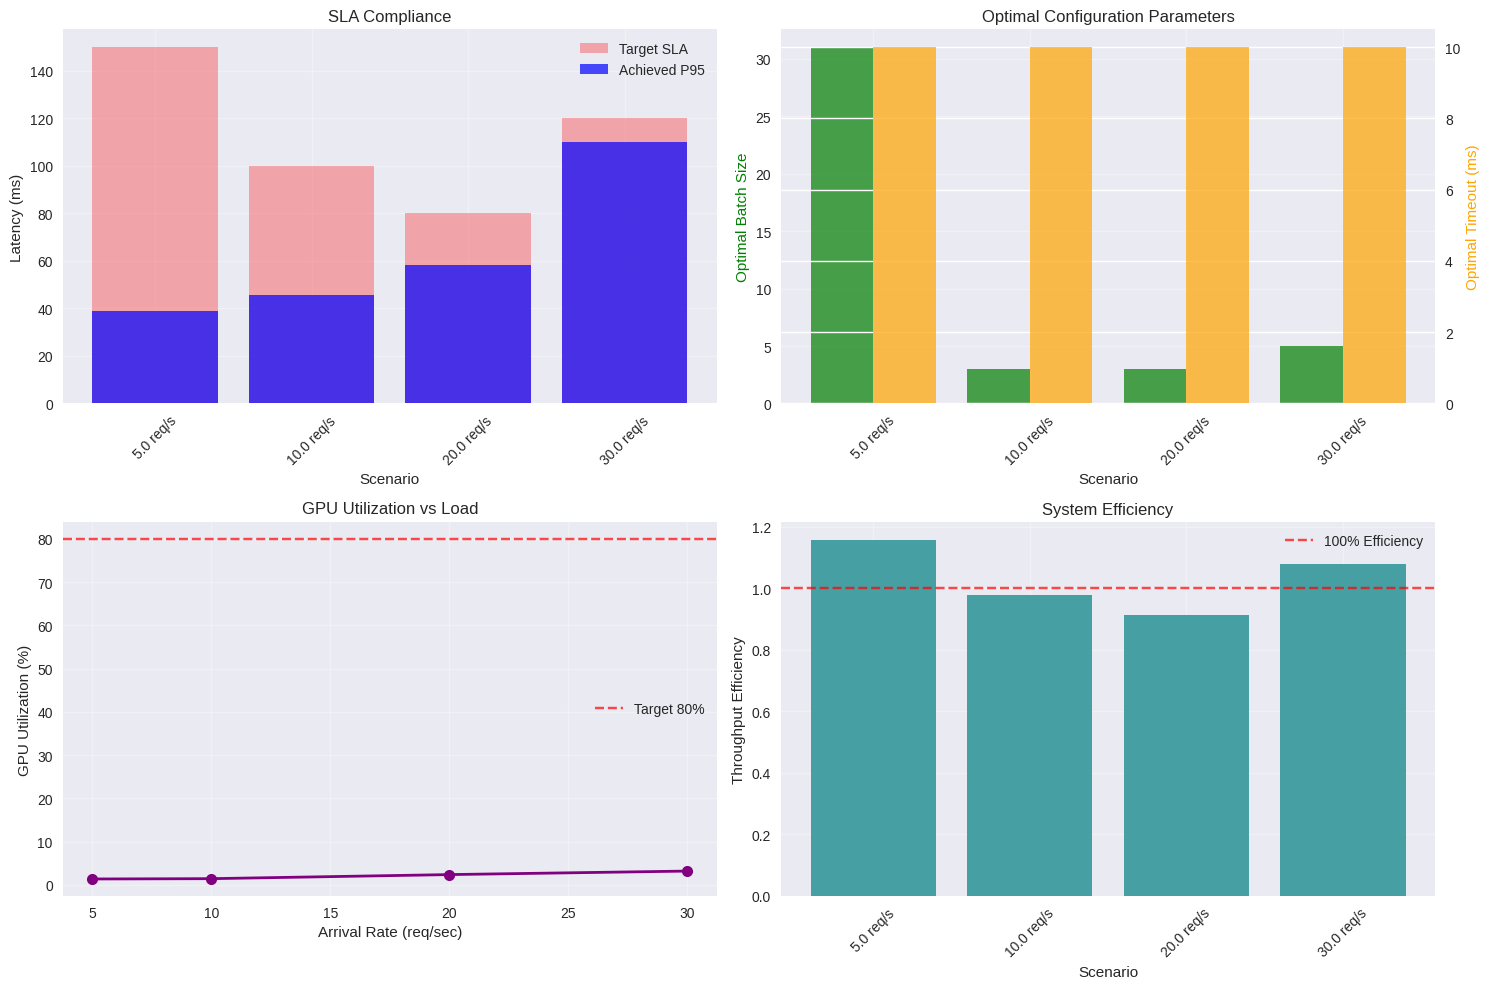

In [11]:
class ProductionBatchingSystem:
    """Production-ready batching system with monitoring and optimization"""
    
    def __init__(self, simulator: ModelInferenceSimulator):
        self.simulator = simulator
        self.metrics = {
            'total_requests': 0,
            'total_batches': 0,
            'total_processing_time': 0.0,
            'latency_histogram': [],
            'batch_size_histogram': [],
            'gpu_utilization': []
        }
        
    def calculate_optimal_batch_size(self, arrival_rate: float, 
                                   latency_sla: float) -> Tuple[int, float]:
        """Calculate optimal batch size and timeout for given constraints"""
        best_batch_size = 1
        best_timeout = 0.01
        best_score = float('inf')
        
        # Test different configurations
        for batch_size in range(1, 33, 2):
            for timeout in [0.01, 0.02, 0.05, 0.1, 0.2]:
                # Estimate performance
                processing_time = self.simulator.calculate_batch_processing_time(batch_size)
                expected_wait_time = timeout / 2  # Average wait
                expected_latency = expected_wait_time + processing_time
                
                # Check if meets SLA
                if expected_latency <= latency_sla:
                    # Calculate efficiency score (lower is better)
                    utilization = batch_size / (arrival_rate * (expected_wait_time + processing_time))
                    score = expected_latency + (1.0 / max(utilization, 0.1))  # Penalty for low utilization
                    
                    if score < best_score:
                        best_score = score
                        best_batch_size = batch_size
                        best_timeout = timeout
        
        return best_batch_size, best_timeout
    
    def monitor_performance(self, responses: List[InferenceResponse]) -> dict:
        """Monitor and analyze system performance"""
        if not responses:
            return {}
        
        latencies = [r.total_latency for r in responses]
        batch_sizes = [r.batch_size for r in responses]
        processing_times = [r.processing_time for r in responses]
        
        # Update metrics
        self.metrics['total_requests'] += len(responses)
        self.metrics['total_batches'] += len(set(r.request_id[:10] for r in responses))  # Approximate
        self.metrics['total_processing_time'] += sum(processing_times)
        self.metrics['latency_histogram'].extend(latencies)
        self.metrics['batch_size_histogram'].extend(batch_sizes)
        
        # Calculate GPU utilization (simplified)
        total_time = max(r.end_time for r in responses) - min(r.start_time - r.queue_time for r in responses)
        actual_processing_time = sum(set(r.processing_time for r in responses))
        utilization = actual_processing_time / total_time if total_time > 0 else 0
        self.metrics['gpu_utilization'].append(utilization)
        
        return {
            'avg_latency': np.mean(latencies),
            'p50_latency': np.percentile(latencies, 50),
            'p95_latency': np.percentile(latencies, 95),
            'p99_latency': np.percentile(latencies, 99),
            'avg_batch_size': np.mean(batch_sizes),
            'throughput': len(responses) / total_time if total_time > 0 else 0,
            'gpu_utilization': utilization
        }
    
    def generate_recommendations(self, current_metrics: dict, 
                               target_latency: float) -> List[str]:
        """Generate optimization recommendations"""
        recommendations = []
        
        if current_metrics.get('p95_latency', 0) > target_latency * 1.2:
            recommendations.append("Consider reducing batch size or timeout to improve latency")
        
        if current_metrics.get('gpu_utilization', 0) < 0.7:
            recommendations.append("GPU utilization is low - consider increasing batch size")
        
        if current_metrics.get('avg_batch_size', 0) < 4:
            recommendations.append("Small average batch size - check if timeout is too aggressive")
        
        if current_metrics.get('p99_latency', 0) > current_metrics.get('p95_latency', 0) * 2:
            recommendations.append("High latency variance - consider priority-based scheduling")
        
        return recommendations

# Demonstrate production optimization
production_system = ProductionBatchingSystem(simulator)

# Test different arrival rates and SLA requirements
scenarios_sla = [
    (5.0, 0.15),   # 5 req/sec, 150ms SLA
    (10.0, 0.10),  # 10 req/sec, 100ms SLA
    (20.0, 0.08),  # 20 req/sec, 80ms SLA
    (30.0, 0.12),  # 30 req/sec, 120ms SLA (relaxed for high load)
]

optimization_results = []

print("=== Production Optimization Analysis ===")
print("\nOptimal Configuration Recommendations:")
print("-" * 60)

for arrival_rate, latency_sla in scenarios_sla:
    optimal_batch_size, optimal_timeout = production_system.calculate_optimal_batch_size(
        arrival_rate, latency_sla)
    
    # Test the optimal configuration
    test_requests = generator.generate_poisson_arrivals(20.0, arrival_rate)
    dynamic_batcher = DynamicBatcher(optimal_batch_size, optimal_timeout, simulator)
    responses = dynamic_batcher.process_requests(test_requests)
    
    metrics = production_system.monitor_performance(responses)
    recommendations = production_system.generate_recommendations(metrics, latency_sla)
    
    optimization_results.append({
        'arrival_rate': arrival_rate,
        'latency_sla': latency_sla,
        'optimal_batch_size': optimal_batch_size,
        'optimal_timeout': optimal_timeout,
        'metrics': metrics
    })
    
    print(f"\nScenario: {arrival_rate} req/sec, {latency_sla*1000:.0f}ms SLA")
    print(f"  Optimal batch size: {optimal_batch_size}")
    print(f"  Optimal timeout: {optimal_timeout*1000:.0f}ms")
    print(f"  Achieved P95 latency: {metrics['p95_latency']*1000:.1f}ms")
    print(f"  GPU utilization: {metrics['gpu_utilization']*100:.1f}%")
    print(f"  Throughput: {metrics['throughput']:.1f} req/sec")
    
    if recommendations:
        print("  Recommendations:")
        for rec in recommendations:
            print(f"    - {rec}")

# Visualize optimization results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

arrival_rates = [r['arrival_rate'] for r in optimization_results]
slas = [r['latency_sla']*1000 for r in optimization_results]
achieved_latencies = [r['metrics']['p95_latency']*1000 for r in optimization_results]
batch_sizes = [r['optimal_batch_size'] for r in optimization_results]
timeouts = [r['optimal_timeout']*1000 for r in optimization_results]
utilizations = [r['metrics']['gpu_utilization']*100 for r in optimization_results]

# SLA compliance
ax1.bar(range(len(arrival_rates)), slas, alpha=0.3, label='Target SLA', color='red')
ax1.bar(range(len(arrival_rates)), achieved_latencies, alpha=0.7, label='Achieved P95', color='blue')
ax1.set_xlabel('Scenario')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('SLA Compliance')
ax1.set_xticks(range(len(arrival_rates)))
ax1.set_xticklabels([f'{rate} req/s' for rate in arrival_rates], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Optimal configurations
ax2_twin = ax2.twinx()
bars1 = ax2.bar([x - 0.2 for x in range(len(arrival_rates))], batch_sizes, 
                width=0.4, label='Batch Size', color='green', alpha=0.7)
bars2 = ax2_twin.bar([x + 0.2 for x in range(len(arrival_rates))], timeouts, 
                     width=0.4, label='Timeout (ms)', color='orange', alpha=0.7)

ax2.set_xlabel('Scenario')
ax2.set_ylabel('Optimal Batch Size', color='green')
ax2_twin.set_ylabel('Optimal Timeout (ms)', color='orange')
ax2.set_title('Optimal Configuration Parameters')
ax2.set_xticks(range(len(arrival_rates)))
ax2.set_xticklabels([f'{rate} req/s' for rate in arrival_rates], rotation=45)
ax2.grid(True, alpha=0.3)

# GPU utilization
ax3.plot(arrival_rates, utilizations, 'o-', linewidth=2, markersize=8, color='purple')
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Target 80%')
ax3.set_xlabel('Arrival Rate (req/sec)')
ax3.set_ylabel('GPU Utilization (%)')
ax3.set_title('GPU Utilization vs Load')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Efficiency analysis
throughputs = [r['metrics']['throughput'] for r in optimization_results]
efficiency = [t/a for t, a in zip(throughputs, arrival_rates)]  # Fraction of incoming load served

ax4.bar(range(len(arrival_rates)), efficiency, alpha=0.7, color='teal')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='100% Efficiency')
ax4.set_xlabel('Scenario')
ax4.set_ylabel('Throughput Efficiency')
ax4.set_title('System Efficiency')
ax4.set_xticks(range(len(arrival_rates)))
ax4.set_xticklabels([f'{rate} req/s' for rate in arrival_rates], rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Summary and Key Takeaways

### Dynamic vs Continuous Batching: When to Use What

**Static Batching:**
- ✅ Predictable workloads with steady traffic
- ✅ Maximum GPU utilization
- ✅ Simple implementation
- ❌ Poor latency for variable traffic
- ❌ Can cause request starvation

**Dynamic Batching:**
- ✅ Good balance of latency and throughput
- ✅ Handles variable traffic well
- ✅ Configurable timeout provides latency bounds
- ❌ More complex than static
- ❌ Still waits for batch completion

**Continuous Batching:**
- ✅ Best latency for bursty traffic
- ✅ Overlapping processing reduces idle time
- ✅ Excellent for latency-sensitive applications
- ❌ Most complex implementation
- ❌ Requires careful memory management

### Production Implementation Guidelines

1. **Start with Dynamic Batching**: Good default choice for most applications
2. **Monitor Key Metrics**: P95 latency, GPU utilization, throughput
3. **Adaptive Configuration**: Adjust batch size and timeout based on load
4. **Consider Request Priorities**: Use fair-share or priority-aware scheduling
5. **Plan for Burst Traffic**: Continuous batching for latency-critical services

### Performance Optimization Checklist

- [ ] Profile your model's batch processing characteristics
- [ ] Establish latency SLAs for different request types
- [ ] Implement comprehensive monitoring and alerting
- [ ] Test with realistic traffic patterns
- [ ] Plan for failover and degraded performance scenarios
- [ ] Consider memory constraints and OOM prevention
- [ ] Implement request prioritization if needed
- [ ] Use A/B testing for configuration optimization

This notebook provides a comprehensive foundation for understanding and implementing batching strategies in production ML inference systems. The trade-offs between latency and throughput are fundamental to system design, and the choice of batching strategy should align with your specific performance requirements and traffic patterns.